In [147]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.framework.load_library import imp
# import tensorflow_addons as tfa
import keras
import os
import time
import pickle as pkl

# from tensorflow_addons.layers import MaxUnpooling2D
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Flatten,Dense,Reshape,Conv2DTranspose,LeakyReLU,UpSampling2D,Layer,InputSpec
import keras.backend as K
from keras.models import Model,load_model
from keras.optimizers import adam_v2,gradient_descent_v2
from keras import  losses,metrics
from keras.callbacks import EarlyStopping, CSVLogger
from sklearn.cluster import KMeans
# from sklearn import metrics
from keras.utils.vis_utils import plot_model
from IPython.display import HTML, Image

plt.rcParams['font.sans-serif'] = ['SimHei']  # 引入中文
plt.rcParams['axes.unicode_minus'] = False  # 引入负号

In [120]:
date_name = 1028

#### DATA

In [148]:
trainx=pd.read_pickle(r"E:\\vscode\work\\VEA\\数据构造\\m_data\\auto_del0_30_trainx.pkl")
testx=pd.read_pickle(r"E:\\vscode\work\\test\data\\testx_step2.pkl")


In [122]:
# skip=2
# trainx=trainx[::skip,:,:,:]
# testx=testx[::skip,:,:,:]
# senlist=[2,6]
# for sen in senlist:
#     trainx[:,sen,:,:]=0
#     trainx[:,:,sen,:]=0
#     testx[:,sen,:,:]=0
#     testx[:,:,sen,:]=0

# for sen in senlist:
#     trainx=np.delete(trainx,sen,1)
#     trainx=np.delete(trainx,sen,2)
#     testx=np.delete(testx,sen,1)
#     testx=np.delete(testx,sen,2)

In [123]:
m,n,o,p = trainx.shape

In [124]:
# Designate GPU to run model training
os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [125]:
# #limit GPU memory use:
GPUfrac=1.00
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=GPUfrac)#, allow_growth=True)
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
K.set_session(sess)

In [126]:
# np.random.seed(812) # 812  1012

#### AE

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 8, 8, 50)]        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 160)         72160     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 64)          92224     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 4, 48)          27696     
_________________________________________________________________
flatten_5 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 368)               

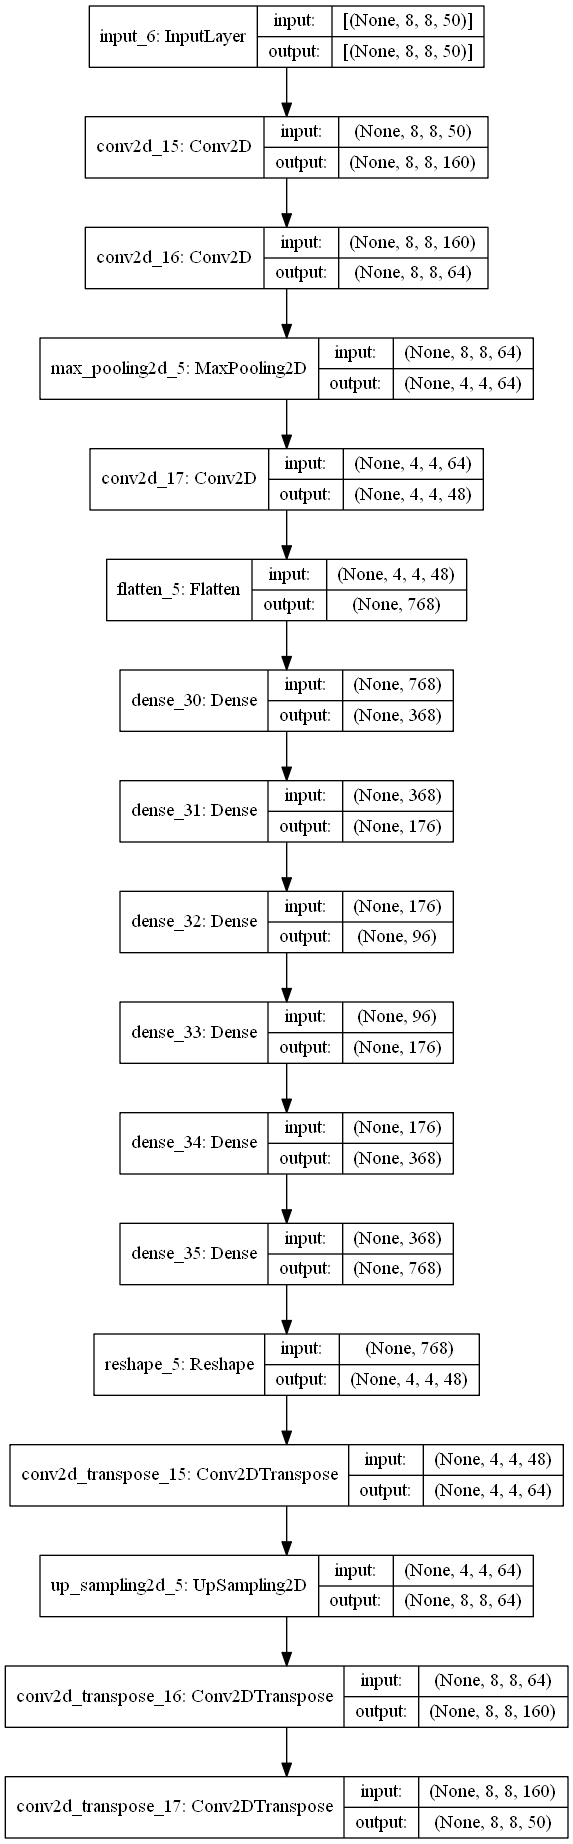

In [127]:
u1,u2,u3 = 368,176,96
a1,a2,a3,a4,a5 = 'elu','relu','softplus','elu','relu'
f1,f2,f3 = 160,64,48

img_input = Input(shape=(n,o,p)) #(8,8,len(T))

e = Conv2D(f1, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same', strides=[1,1])(img_input)
e = Conv2D(f2, (3, 3), activation=a5, padding='same', strides=[1,1])(e)
e = MaxPooling2D(pool_size=(2,2),strides=[2,2])(e)
e = Conv2D(f3, (3, 3), activation=a4, padding='same', strides=[1,1])(e)
shape_before_flattening = K.int_shape(e)
e = Flatten()(e)
e = Dense(u1,activation=a1)(e)
e = Dense(u2,activation=a2)(e)

encoded = Dense(u3,activation=a3)(e)

d = Dense(u2,activation=a3)(encoded)
d = Dense(u1,activation=a2)(d)
d = Dense(np.prod(shape_before_flattening[1:]),activation=a1)(d)
d = Reshape(shape_before_flattening[1:])(d)
d = Conv2DTranspose(f2, (3, 3), strides=[1,1], activation=a4, padding='same')(d)
d = UpSampling2D((2,2))(d)
d = Conv2DTranspose(f1, (3, 3), strides=[1,1], activation=a5, padding='same')(d)

decoded = Conv2DTranspose(p, (3, 3), strides=[1,1], activation=LeakyReLU(alpha=0.01), padding='same')(d)

autoencoder = Model(inputs=img_input, outputs=decoded, name='autoencoder')
encoder = Model(inputs=img_input, outputs=encoded, name='encoder')

autoencoder.build((None,8,8,p))
autoencoder.summary()
encoder.summary()

architecture_fname = 'CAE_Model.png'
plot_model(autoencoder, to_file=architecture_fname, show_shapes=True)
Image(filename=architecture_fname)

##### fit

In [128]:
LR = 0.00065             #Learning rate

n_epochs = 200         #Number of epochs

batch_sz = 512          #Batch size

#create log file to record training & validation loss 
logger_fname = 'HistoryLog_LearningCurve.csv'
csv_logger = CSVLogger(logger_fname)

# Early stopping halts training after validation loss stops decreasing for 10 consectutive epochs
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1,
                           mode='min', restore_best_weights=True)
            

In [129]:
optim = adam_v2.Adam(learning_rate=LR)             #Adaptive learning rate optimization algorithm (Adam)
loss = losses.MeanSquaredError()        #Mean Squared Error Loss function

#Compile Encoder & Autoencoder(initialize random filter weights)
encoder.compile(loss=loss,optimizer=optim) 
autoencoder.compile(loss=loss,
                  optimizer=optim,
                  metrics=[metrics.mae])   

In [130]:
autoencoder.fit(trainx, trainx,
                epochs=n_epochs,
                batch_size=batch_sz,
                shuffle=True,
                validation_data=(testx, testx),
                callbacks=[csv_logger, early_stop])

Epoch 1/200
14/14 [==============================] - 3s 148ms/step - loss: 0.0998 - mean_absolute_error: 0.2568 - val_loss: 0.0865 - val_mean_absolute_error: 0.2311
Epoch 2/200
14/14 [==============================] - 1s 74ms/step - loss: 0.0776 - mean_absolute_error: 0.2116 - val_loss: 0.0769 - val_mean_absolute_error: 0.2052
Epoch 3/200
14/14 [==============================] - 1s 64ms/step - loss: 0.0724 - mean_absolute_error: 0.1961 - val_loss: 0.0737 - val_mean_absolute_error: 0.1965
Epoch 4/200
14/14 [==============================] - 1s 63ms/step - loss: 0.0694 - mean_absolute_error: 0.1893 - val_loss: 0.0706 - val_mean_absolute_error: 0.1985
Epoch 5/200
14/14 [==============================] - 1s 58ms/step - loss: 0.0629 - mean_absolute_error: 0.1907 - val_loss: 0.0560 - val_mean_absolute_error: 0.1857
Epoch 6/200
14/14 [==============================] - 1s 66ms/step - loss: 0.0455 - mean_absolute_error: 0.1666 - val_loss: 0.0372 - val_mean_absolute_error: 0.1497
Epoch 7/200
14/

In [131]:
hist = np.genfromtxt(logger_fname, delimiter=',', skip_header=1, names=['epoch', 'train_mse_loss', 'train_mae_loss', 'val_mse_loss', 'val_mae_loss'])

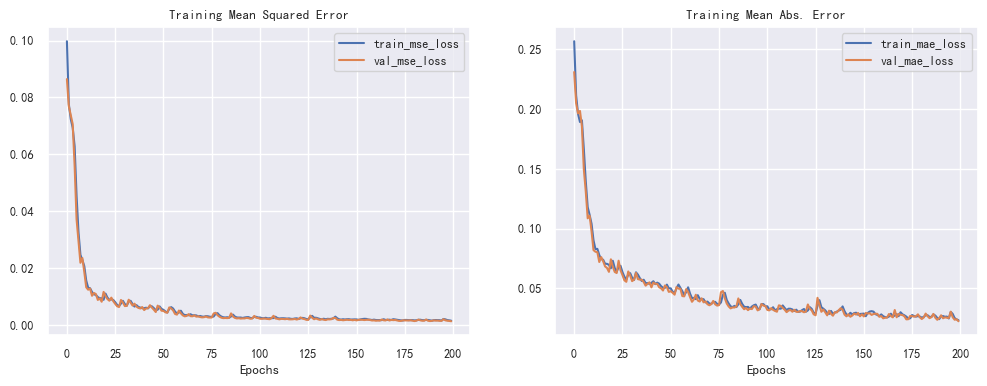

In [132]:
plt.figure(figsize=(12,4),dpi=100)

plt.subplot(1,2,2)
plt.plot(hist['epoch'], hist['train_mae_loss'], label='train_mae_loss')
plt.plot(hist['epoch'], hist['val_mae_loss'], label='val_mae_loss')
plt.xlabel('Epochs')
plt.title('Training Mean Abs. Error')
plt.legend()

plt.subplot(1,2,1)
plt.plot(hist['epoch'], hist['train_mse_loss'], label='train_mse_loss')
plt.plot(hist['epoch'], hist['val_mse_loss'], label='val_mse_loss')
plt.xlabel('Epochs')
plt.title('Training Mean Squared Error')
plt.legend()

# plt.savefig('./Figures/MSE_MAE_Subplots_Loss_Learning_Curve.png')
plt.show()

In [133]:
#Save initial model architectures with weights. 
autoencoder.save('Saved_Autoencoder_{}.hdf5'.format(date_name))
encoder.save("Saved_Encoder1_{}.hdf5".format(date_name))

##### load model

In [134]:
# autoencoder=load_model('Saved_Autoencoder_{}.hdf5'.format(date_name))
# encoder=load_model("Saved_Encoder1_{}.hdf5".format(date_name))

#### ClusteringLayer

In [135]:
n_clusters=4

...Finetuning...


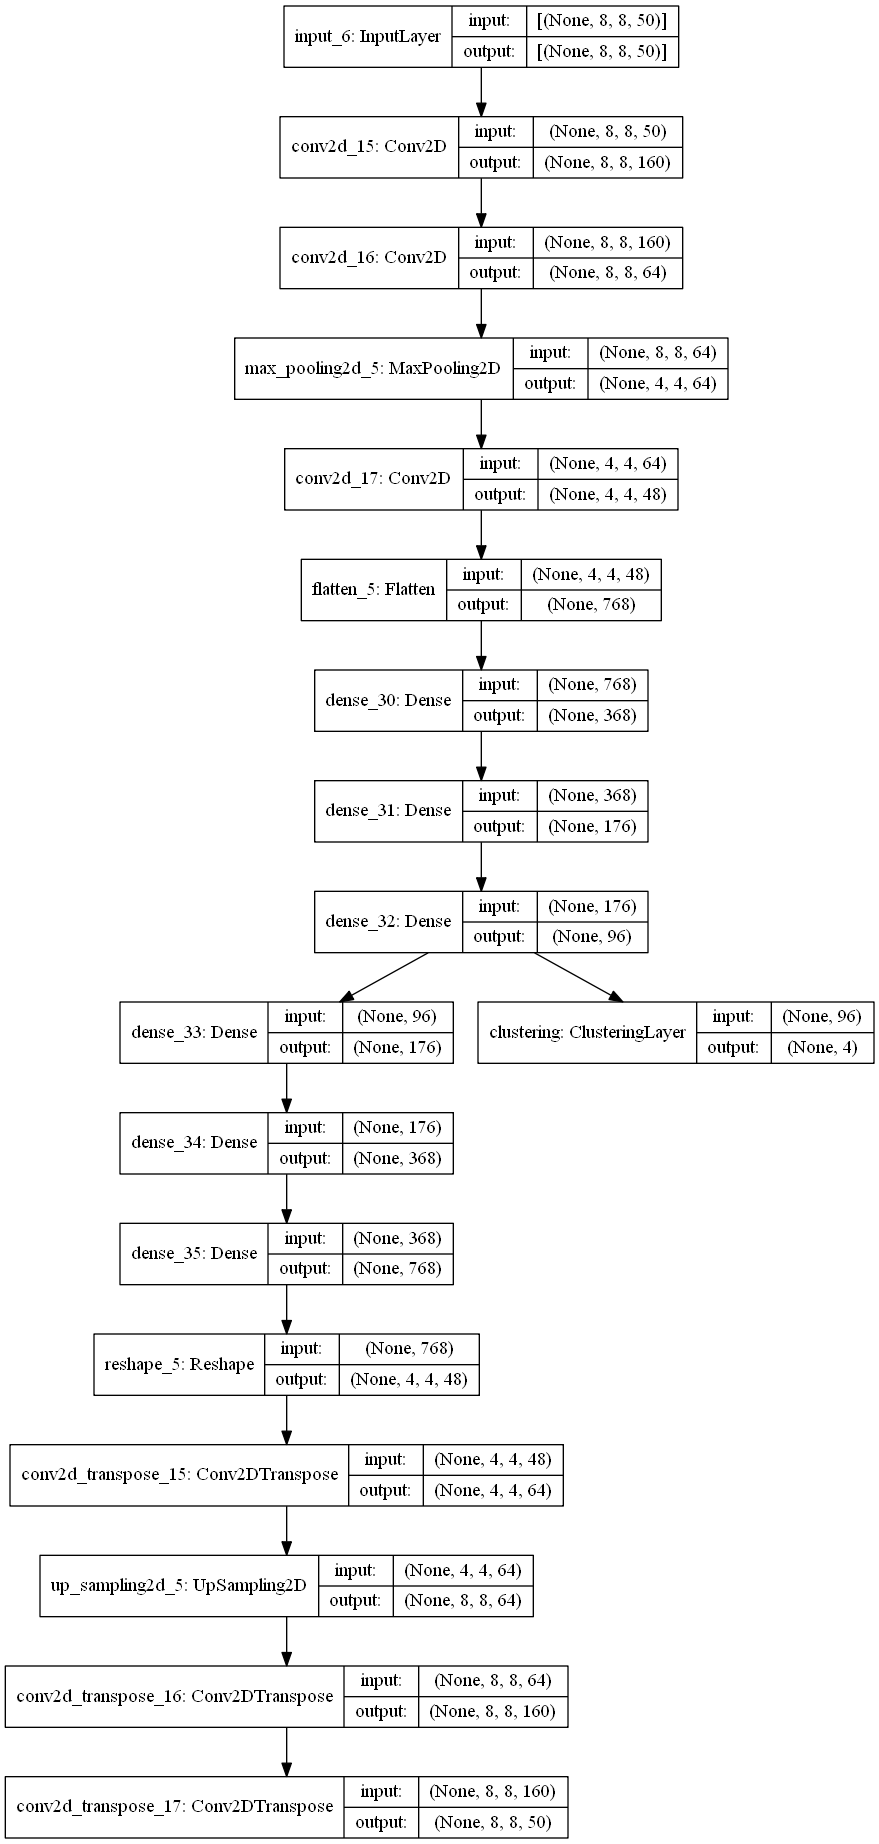

In [136]:
#### clustering layers:
from numpy import shape


class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs): #self is place holder for futre object 
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        #initialize object attributes
        self.n_clusters = n_clusters 
        self.alpha = alpha #exponent for soft assignment calculation
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim),initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) 
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
print('...Finetuning...')   
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)       #Feed embedded samples to 
                                                                                        #clustering layer
    
model = Model(inputs=autoencoder.input, outputs=[clustering_layer, autoencoder.output]) #Input: Spectrograms, 
                                                                                        #Output: Cluster assignments 
                                                                                        #      & Reconstructions            

optim2 = adam_v2.Adam(learning_rate=0.0085)                                                                                        
model.compile(loss=['kld',loss], loss_weights=[0.1,0.9], optimizer=optim2) # Initialize model parameters

#Save and Show full DEC model architecture
DEC_model_fname = 'DEC_CAE_Model_{}.png'.format(date_name)
plot_model(model, to_file=DEC_model_fname, show_shapes=True)
from IPython.display import Image
Image(filename=DEC_model_fname)

##### kmeans

In [137]:
enc_train = encoder.predict(trainx, verbose=1)    # generate embedded latent space training samples

### initializing the weights using Kmean and assigning them to the model
#---------------------------------------------------------------------------------------------------------------------------
kmeans = KMeans(n_clusters, n_init=100) # run kmeans with n_clusters, run 100 initializations to ensure accuracy

labels = kmeans.fit_predict(enc_train)             # get initial assignments

labels_last = np.copy(labels)                      # make copy of labels for future reference (see DEC training below)

# initialize the DEC clustering layer weights using cluster centers found initally by kmeans.                                                                         
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_]) 

214/214 [==============================] - 1s 3ms/step


d:\software\anaconda3\envs\TF\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=27.
  warnings.warn(


In [138]:
def print_cluster_size(labels):
    """
    Shows the number of samples assigned to each cluster. 
    # Example 
    ```
        print_cluster_size(labels=kmeans_labels)
    ```
    # Arguments
        labels: 1D array  of clustering assignments. The value of each label corresponds to the cluster 
                that the samples in the clustered data set (with the same index) was assigned to. Array must be the same length as
                data.shape[0]. where 'data' is the clustered data set. 
    """
    num_labels = max(labels) + 1
    for j in range(0,num_labels):
        label_idx = np.where(labels==j)[0]
        print("Label " + str(j) + ": " + str(label_idx.shape[0]))

##### trainy

In [150]:
trainy=pd.read_pickle(r'E:\vscode\work\VEA\数据构造\m_data\auto_del0_30_trainy.pkl')
testy=pd.read_pickle('E:\\vscode\work\\test\data\\trainy_step2.pkl')
# trainy=trainy[::skip]
# testy=testy[::skip]
# 4分类
trainy[np.where(trainy==3)]=0
trainy[np.where(trainy==4)]=3

# testy[np.where(testy==3)]=0
# testy[np.where(testy==4)]=3
print_cluster_size(testy)

Label 0: 8262
Label 1: 14964
Label 2: 12149
Label 3: 7642
Label 4: 11654


Text(0.5, 67.74999999999994, 'Clustering label')

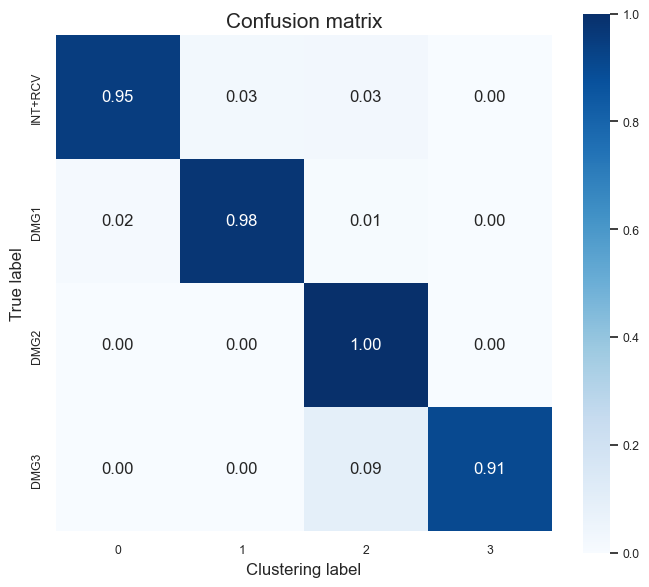

In [146]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})



import sklearn.metrics
sns.set(font_scale=0.8)
confusion_matrix = sklearn.metrics.confusion_matrix(trainy, labels_last)
confusion_matrix_new=np.zeros(confusion_matrix.shape)
for i in range(len(confusion_matrix)):
    confusion_matrix_new[i]=confusion_matrix[i]/np.sum(confusion_matrix[i])

# 将混淆矩阵化为对角线
change_inx=np.argmax(confusion_matrix_new,axis=0)
labels_last_new=np.copy(labels_last)
for i in range(len(change_inx)):
    labels_last_new[np.where(labels_last==i)]=change_inx[i]

confusion_matrix = sklearn.metrics.confusion_matrix(trainy, labels_last_new)
confusion_matrix_new=np.zeros(confusion_matrix.shape)
for i in range(len(confusion_matrix)):
    confusion_matrix_new[i]=confusion_matrix[i]/np.sum(confusion_matrix[i])

plt.figure(figsize=(8,7))
sns.heatmap(confusion_matrix_new, annot=True, fmt=".2f", annot_kws={"size": 12},cmap="Blues",square=True)
plt.title("Confusion matrix", fontsize=15)
plt.ylabel('True label', fontsize=12)
plt.yticks(ticks=(0.5,1.5,2.5,3.5),labels=('INT+RCV','DMG1','DMG2','DMG3'))
plt.xlabel('Clustering label', fontsize=12)

In [96]:
import pickle as pkl
with open(r"trainy_kmeans_predict.pkl",'wb+') as f:
    pkl.dump(labels_last_new,f,protocol=4)

In [112]:
enc_train = encoder.predict(testx, verbose=1)
labels = kmeans.predict(enc_train)            
labels_last = np.copy(labels) 

449/449 [==============================] - 1s 3ms/step


Text(0.5, 67.74999999999994, 'Clustering label')

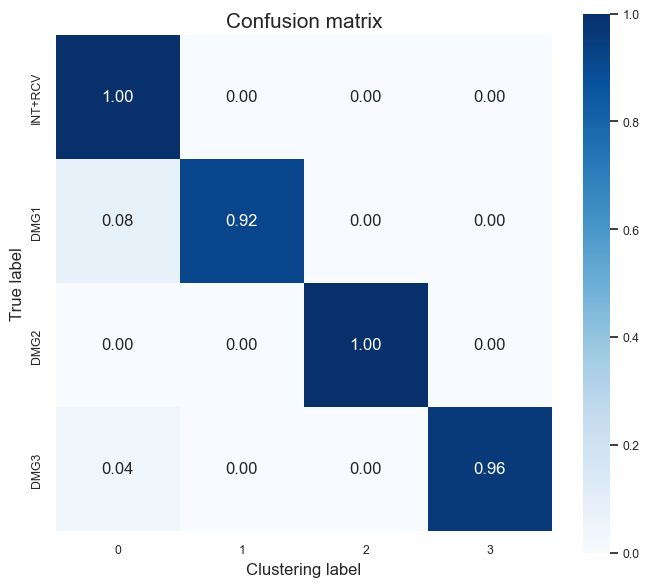

In [113]:
sns.set(font_scale=0.8)
confusion_matrix = sklearn.metrics.confusion_matrix(testy, labels_last)
confusion_matrix_new=np.zeros(confusion_matrix.shape)
for i in range(len(confusion_matrix)):
    confusion_matrix_new[i]=confusion_matrix[i]/np.sum(confusion_matrix[i])

# 将混淆矩阵化为对角线
change_inx=np.argmax(confusion_matrix_new,axis=0)
labels_last_new=np.copy(labels_last)
for i in range(len(change_inx)):
    labels_last_new[np.where(labels_last==i)]=change_inx[i]

confusion_matrix = sklearn.metrics.confusion_matrix(testy, labels_last_new)
confusion_matrix_new=np.zeros(confusion_matrix.shape)
for i in range(len(confusion_matrix)):
    confusion_matrix_new[i]=confusion_matrix[i]/np.sum(confusion_matrix[i])

plt.figure(figsize=(8,7))
sns.heatmap(confusion_matrix_new, annot=True, fmt=".2f", annot_kws={"size": 12},cmap="Blues",square=True)
plt.title("Confusion matrix", fontsize=15)
plt.ylabel('True label', fontsize=12)
plt.yticks(ticks=(0.5,1.5,2.5,3.5),labels=('INT+RCV','DMG1','DMG2','DMG3'))
plt.xlabel('Clustering label', fontsize=12)

In [114]:
with open(r"testy_kmeans_predict.pkl",'wb+') as f:
    pkl.dump(labels_last_new,f,protocol=4)

##### train deep embedded clustering

In [115]:
# Parameters for the  DEC finetuning
#--------------------------------------------------------------------------------------------------------------------
batch_size=256                     # number of samples in each batch
tol = 0.001                        # tolerance threshold to stop training
loss = 0                           # initialize loss
index = 0                          # initialize index to start 
maxiter = 24576                  # number of updates to rub before halting. (~12 epochs)
update_interval = 315              # Soft assignment distribution and target distributions updated evey 315 batches. 
                                   #(~12 updates/epoch)
index_array = np.arange(trainx.shape[0])
np.random.shuffle(index_array)
label_l=[]

In [116]:
###############################################################################
### simultaneous optimization and clustering
def target_distribution(q):
    """
    Compute the target distribution p, given soft assignements, q. The target distribtuion is generated by giving
    more weight to 'high confidence' samples - those with a higher probability of being a signed to a certain cluster. 
    This is used in the KL-divergence loss function.
    # Arguments
        q: Soft assignement probabilities - Probabilities of each sample being assigned to each cluster.
    # Input:
         2D tensor of shape [n_samples, n_features].
    # Output:
        2D tensor of shape [n_samples, n_features].
    """
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T


tic = time.time()
loss_list = np.zeros([maxiter,3])                       # Keep track of loss function during training process
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, reconst  = model.predict(trainx, verbose=1) # Calculate soft assignment distribtuion & CAE reconstructions
        
        p = target_distribution(q)                      # Update the auxiliary target distribution p       
        
        labels = q.argmax(1)                            # Assign labels to the embedded latent space samples
        

        # check stop criterion - Calculate the % of labels that changed from previous update
        delta_label = np.sum(labels != labels_last).astype(np.float32) /labels.shape[0] 
        
        labels_last = np.copy(labels)                   # Generate copy of labels for future updates
        label_l.append(labels_last)

        loss= np.round(loss, 5)                         # Round the loss 
        
        print('Iter %d' % ite)
        print('Loss: {}'.format(loss))
        print_cluster_size(labels)                      # Show the number of samples assigned to each cluster
        

        if ite > 0 and delta_label < tol:               # Break training if loss reaches the tolerance threshhold
            print('delta_label ', delta_label, '< tol ', tol)
            break
    
    idx = index_array[index * batch_size: min((index+1) * batch_size, trainx.shape[0])]
    loss = model.train_on_batch(x=trainx[idx], y=[p[idx], trainx[idx]])
    index = index + 1 if (index + 1) * batch_size <= trainx.shape[0] else 0        
        
#Save model and model weights seperately
model.save_weights('./DEC_model_final_{}.h5'.format(date_name))
model.save('Saved_DEC_model_{}.hdf5'.format(date_name))

toc = time.time()
print('Deep Embedded Clustering Computation Time : {0:4.1f} minutes'.format((toc-tic)/60))


1709/1709 [==============================] - 7s 4ms/step


C:\Users\DELL\AppData\Local\Temp\ipykernel_13340\504638634.py:31: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  delta_label = np.sum(labels != labels_last).astype(np.float32) /labels.shape[0]


Iter 0
Loss: 0
Label 0: 10594
Label 1: 12149
Label 2: 14147
Label 3: 17781
1709/1709 [==============================] - 7s 4ms/step
Iter 315
Loss: [0.15838 1.01873 0.06278]
Label 0: 0
Label 1: 54671
1709/1709 [==============================] - 7s 4ms/step
Iter 630
Loss: [0.03995 0.      0.04439]
Label 0: 0
Label 1: 54671
delta_label  0.0 < tol  0.001
Deep Embedded Clustering Computation Time :  1.3 minutes


In [44]:
# import pickle as pkl
# with open(r"labels_last_3.pkl",'wb+') as f:
#     pkl.dump(labels_last,f,protocol=4)

#### 画图

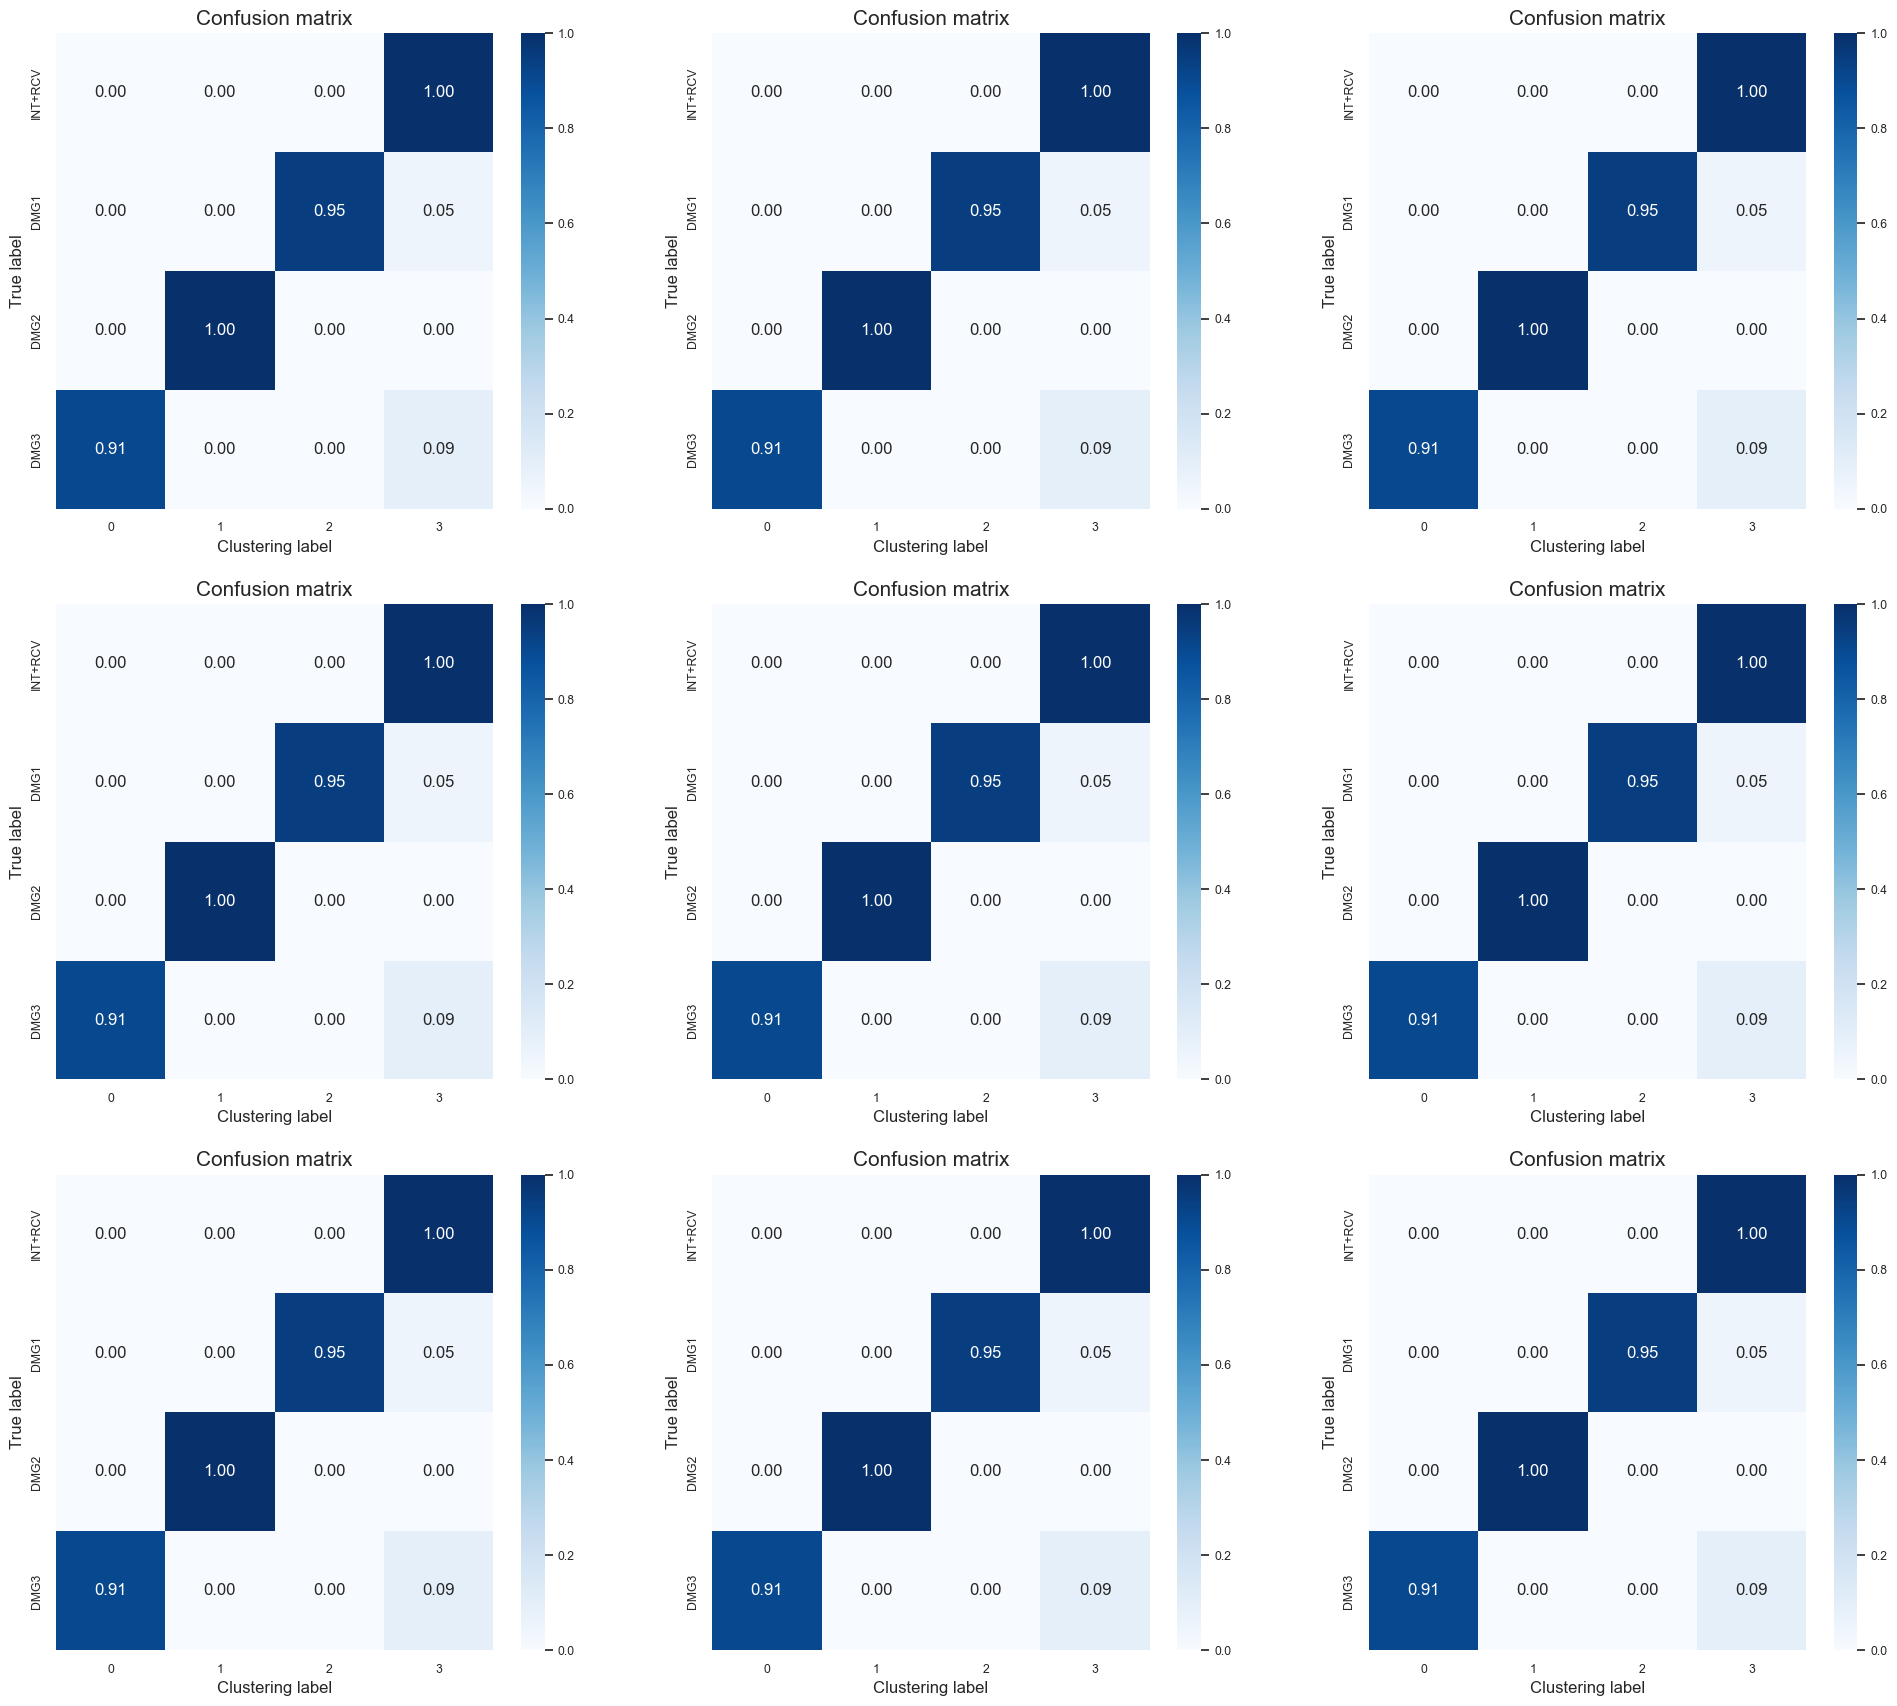

In [117]:
import sklearn.metrics
import matplotlib.pyplot as plt
plt.figure(figsize=(24,21))
for i in range(9):
    plt.subplot(3,3,i+1)
    sns.set(font_scale=0.8)
    confusion_matrix = sklearn.metrics.confusion_matrix(trainy, label_l[(i+1)*((len(label_l)-1)//9)])
    confusion_matrix_new=np.zeros(confusion_matrix.shape)
    for j in range(len(confusion_matrix)):
        confusion_matrix_new[j]=confusion_matrix[j]/np.sum(confusion_matrix[j])

    # plt.figure(figsize=(8,7))
    sns.heatmap(confusion_matrix_new, annot=True, fmt=".2f", annot_kws={"size": 12},cmap="Blues")
    plt.title("Confusion matrix", fontsize=15)
    plt.ylabel('True label', fontsize=12)
    plt.yticks(ticks=(0.5,1.5,2.5,3.5),labels=('INT+RCV','DMG1','DMG2','DMG3'))
    plt.xlabel('Clustering label', fontsize=12)
plt.show()

In [ ]:
sns.set(font_scale=0.8)
confusion_matrix = sklearn.metrics.confusion_matrix(trainy, labels_last)
# confusion_matrix = sklearn.metrics.confusion_matrix(trainy, label_l[-2])
confusion_matrix_new=np.zeros(confusion_matrix.shape)
for i in range(len(confusion_matrix)):
    confusion_matrix_new[i]=confusion_matrix[i]/np.sum(confusion_matrix[i])

change_inx=np.argmax(confusion_matrix_new,axis=0)
labels_last_new=np.copy(labels_last)
for i in range(len(change_inx)):
    labels_last_new[np.where(labels_last==i)]=change_inx[i]

confusion_matrix = sklearn.metrics.confusion_matrix(trainy, labels_last_new)
confusion_matrix_new=np.zeros(confusion_matrix.shape)
for i in range(len(confusion_matrix)):
    confusion_matrix_new[i]=confusion_matrix[i]/np.sum(confusion_matrix[i])

plt.figure(figsize=(8,7))
sns.heatmap(confusion_matrix_new, annot=True, fmt=".2f", annot_kws={"size": 12},cmap="Blues",square=True)
plt.title("Confusion matrix", fontsize=15)
plt.ylabel('True label', fontsize=12)
plt.yticks(ticks=(0.5,1.5,2.5,3.5),labels=('INT+RCV','DMG1','DMG2','DMG3'))
plt.xlabel('Clustering label', fontsize=12)

In [67]:
import pickle as pkl
with open(r"trainy_predict.pkl",'wb+') as f:
    pkl.dump(labels_last_new,f,protocol=4)

#### test

In [115]:
q, reconst  = model.predict(testx, verbose=1)
p = target_distribution(q) 
labels_last = q.argmax(1)
trainy = testy

449/449 [==============================] - 2s 4ms/step


Text(0.5, 67.74999999999994, 'Clustering label')

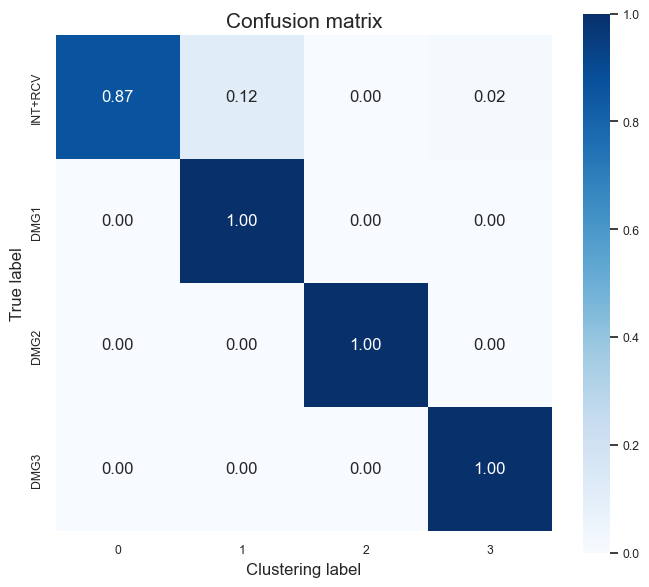

In [116]:
sns.set(font_scale=0.8)
confusion_matrix = sklearn.metrics.confusion_matrix(trainy, labels_last)
# confusion_matrix = sklearn.metrics.confusion_matrix(trainy, label_l[-2])
confusion_matrix_new=np.zeros(confusion_matrix.shape)
for i in range(len(confusion_matrix)):
    confusion_matrix_new[i]=confusion_matrix[i]/np.sum(confusion_matrix[i])

change_inx=np.argmax(confusion_matrix_new,axis=0)
labels_last_new=np.copy(labels_last)
for i in range(len(change_inx)):
    labels_last_new[np.where(labels_last==i)]=change_inx[i]

confusion_matrix = sklearn.metrics.confusion_matrix(trainy, labels_last_new)
confusion_matrix_new=np.zeros(confusion_matrix.shape)
for i in range(len(confusion_matrix)):
    confusion_matrix_new[i]=confusion_matrix[i]/np.sum(confusion_matrix[i])

plt.figure(figsize=(8,7))
sns.heatmap(confusion_matrix_new, annot=True, fmt=".2f", annot_kws={"size": 12},cmap="Blues",square=True)
plt.title("Confusion matrix", fontsize=15)
plt.ylabel('True label', fontsize=12)
plt.yticks(ticks=(0.5,1.5,2.5,3.5),labels=('INT+RCV','DMG1','DMG2','DMG3'))
plt.xlabel('Clustering label', fontsize=12)

In [118]:
with open(r"testy_predict.pkl",'wb+') as f:
    pkl.dump(labels_last,f,protocol=4)

In [119]:
idec_enc_train = encoder.predict(trainx, verbose=1)

1709/1709 [==============================] - 4s 2ms/step


In [120]:
with open(r"data/idec_enc_train.pkl",'wb+') as f:
    pkl.dump(idec_enc_train,f,protocol=4)

##### t-SNE

In [47]:
# enc_train_c = encoder.predict(trainx, verbose=1)

In [48]:
# from sklearn.manifold import TSNE
# enc_t = TSNE().fit_transform(enc_train_c)

In [49]:
# def scatter(x, colors):
#     # We choose a color palette with seaborn.
#     palette = np.array(sns.color_palette("hls", 5))

#     # We create a scatter plot.
#     plt.figure(figsize=(8, 8))
#     for i in range(5):
#         plt.scatter(x[colors == i,0], x[colors == i,1], lw=0, s=40,
#                         c=palette[i])
#     plt.xlim(-25, 25)
#     plt.ylim(-25, 25)
#     plt.axis('off')
#     plt.axis('tight')


# scatter(enc_t, trainy)
# plt.legend(['INT','DMG1','DMG2','RCV','DMG3'], loc='upper right')
# # plt.savefig('./results/cov_digits_tsne-generated_nonor.png', dpi=120)
# plt.show()